In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io


Набор данных ex3data1.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X (изменения уровня воды) и y (объем воды, вытекающий из дамбы). По переменной X необходимо предсказать y. Данные разделены на три выборки: обучающая выборка (X, y), по которой определяются параметры модели; валидационная выборка (Xval, yval), на которой настраивается коэффициент регуляризации; контрольная выборка (Xtest, ytest), на которой оценивается качество построенной модели.

**1. Загрузите данные ex3data1.mat из файла.**

In [17]:
data = scipy.io.loadmat( 'ex3data1.mat' )

In [368]:
X_train, y_train = data['X'], data['y']

X_valid, y_valid = data['Xval'], data['yval']

X_test, y_test = data['Xtest'], data['ytest']

# добавляем  bias

X_train = np.insert(X_train, 0, 1, axis=1)
X_valid = np.insert(X_valid, 0, 1, axis=1)
X_test = np.insert(X_test, 0, 1, axis=1)

**2. Постройте график, где по осям откладываются X и y из обучающей выборки.**

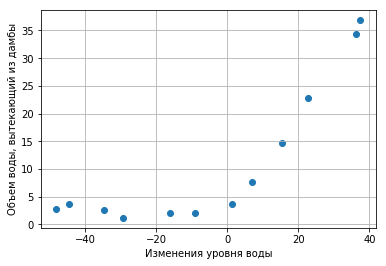

In [150]:
plt.scatter(X_train[:,1], y_train)
plt.ylabel('Объем воды, вытекающий из дамбы')
plt.xlabel('Изменения уровня воды')
plt.grid()
plt.show()

**3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.**

In [23]:
def h(theta, X):
    return np.dot(X, theta)

In [99]:
def J(theta, X, y, lmb = 0.):
    m = len(X)
    error = 0
    reg = 0
    
    h_res = h(theta, X).reshape(-1, 1)
    error = np.sum(np.power((h_res - y), 2)) / ( 2 * m )
    
    if lmb != 0:
        reg = np.sum(np.power(theta[1:], 2) * lmb ) / ( 2 * m )
    
    return error + reg

In [100]:
theta = np.zeros(X_train.shape[1])

In [115]:
J([1, 1], X_train, y_train, 0.5)

303.9723588869309

**4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.**

In [130]:
def gd_step(theta, X, y, lmb = 0.):
    m = len(X)
    gradient = 0    
    
    h_res = h(theta, X).reshape(-1, 1)
    
    gradient = np.dot(X.T, (h_res - y)) / m
    
    if lmb != 0: 
        reg = ((lmb / m) * np.array(theta)).reshape(-1, 1)
        gradient += reg
    
    return gradient

def gd_step_flatten(theta, X, y, lmb = 0.):
    return gd_step(theta, X, y, lmb).flatten()

In [131]:
gd_step_flatten([1, 1], X_train, y_train, 0.5)

array([-15.26134901, 598.20907751])

**5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта 2. Почему регуляризация в данном случае не сработает?**

In [143]:
def lin_reg(X, y, lmb = 0.):
    theta = np.zeros(X.shape[1])
    calc_theta = optimize.fmin_cg(
        J,
        x0=theta,
        fprime=gd_step_flatten,
        args=(X, y, lmb),
        disp=False
    )
    
    return calc_theta

In [166]:
theta_1 = lin_reg(X_train, y_train, 0)

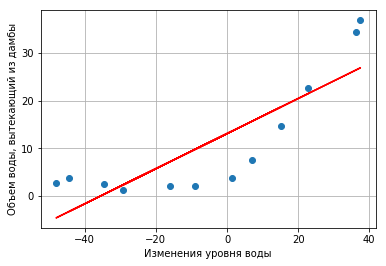

In [167]:
y_pred = h(theta_1, X_train)
plt.scatter(X_train[:,1], y_train)
plt.plot(X_train[:,1], y_pred, 'r-')
plt.ylabel('Объем воды, вытекающий из дамбы')
plt.xlabel('Изменения уровня воды')
plt.grid()
plt.show()

L2-регуляризация помогает решить пробелму переобучения (overfitting, high variance), "сгладить кривую". Если посмотреть на гарфик, то мы увидим, что наша модель страдает от недообучения (underfitting, high bias), следовательно L2-регуляризация тут не поможет.

**6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?**

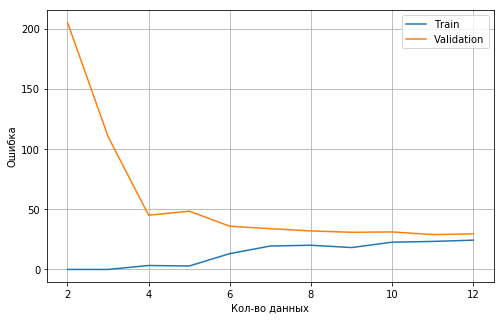

train_error: 24.317249588044152
validation_error: 29.55143162199776


''

In [420]:
def draw_learning_curves(X_train, y_train, X_valid, y_valid, lmb = 0.):
    m = len(X_train)
    
    error_train = []
    error_validation = []
    data_count = []
    
    for i in range(1, m):
        X_train_subset = X_train[:i,:]
        y_subset = y_train[:i]
        theta = lin_reg(X_train_subset, y_subset, lmb)
        
        error_train.append(J(theta, X_train_subset, y_subset, lmb))
        error_validation.append(J(theta, X_valid, y_valid, lmb))
        data_count.append(i + 1)

    plt.figure(figsize=(8,5))
    plt.plot(data_count, error_train, label='Train')
    plt.plot(data_count, error_validation, label='Validation')
    plt.legend()
    plt.xlabel('Кол-во данных')
    plt.ylabel('Ошибка')
    plt.grid(True)
    plt.show()
    
    print(f'train_error: {error_train[-1]}')
    print(f'validation_error: {error_validation[-1]}')

    return error_train, error_validation
    
draw_learning_curves(X_train, y_train, X_valid, y_valid)
''

По графику можно сделать вывод, что модель страдает от "недообучения"(underfitting, high bias). Ошибка модели высока и добавление большего количества данных не принесет значимого прироста точности.

**7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X2, X3, X4, …, Xp).**

In [636]:
def gen_polynom(X, p):
    X_new = np.ones([len(X), p+1])
    for i in range(1, p+1):
        X_new[:, i] = X[:, 1] ** i ;
    
    return X_new

gen_polynom(np.array([[1, 2], [1, 3], [1, 4]]), 3)

array([[ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

**8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.**

In [634]:
def create_normalizer(data):
    wo_bias = data[:,1:]
    mean = np.mean(wo_bias, axis=0)
    range = np.max(wo_bias, axis=0) - np.min(wo_bias, axis=0)
    std = np.std(wo_bias, axis=0)
    
    def norm_func(val):
        cp = val.copy()
        cp[:,1:] -= mean
        #cp[:,1:] /= range
        cp[:,1:] /= std
        
        return cp
    
    def denorm_func(val):
        cp = val.copy()
        #cp[:,1:] *= range
        cp[:,1:] *= std
        cp[:,1:] += mean
        
        return cp
    
    return norm_func, denorm_func

In [549]:
tmp = np.array([
    [1, 3, 0.2],
    [1, 314, 1342,],
    [1, 0.2, 75],
])

In [550]:
norm_func, denorm_func = create_normalizer(tmp)
print('orig')
print(tmp)
print('norm_func')
print(norm_func(tmp))
print('denorm_func')
print(denorm_func(norm_func(tmp)))

orig
[[1.000e+00 3.000e+00 2.000e-01]
 [1.000e+00 3.140e+02 1.342e+03]
 [1.000e+00 2.000e-01 7.500e+01]]
norm_func
[[ 1.         -0.69757921 -0.76698446]
 [ 1.          1.41417096  1.41247286]
 [ 1.         -0.71659175 -0.6454884 ]]
denorm_func
[[1.000e+00 3.000e+00 2.000e-01]
 [1.000e+00 3.140e+02 1.342e+03]
 [1.000e+00 2.000e-01 7.500e+01]]


**9. Обучите модель с коэффициентом регуляризации 0 и p = 8.**

In [629]:
p = 8
X_train_poly = gen_polynom(X_train, p)
X_valid_poly = gen_polynom(X_valid, p)

norm_func, denorm_func = create_normalizer(X_train_poly)

X_train_poly_norm = norm_func(X_train_poly)
X_valid_poly_norm = norm_func(X_valid_poly)


theta_poly_2 = lin_reg(X_train_poly_norm, y_train, 0)

**10. Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?**

In [552]:
def draw_theta(theta, X, Y):
    x = np.linspace(np.min(X)-10, np.max(X)+10, 100).reshape(-1, 1)
    x_pol = gen_polynom(np.insert(x, 0, 1, axis=1), p)

    x_pol = norm_func(x_pol)
    
    y_poly_pred = h(theta, x_pol)

    plt.figure(figsize=(8,5))
    plt.scatter(X[:,1], y_train, color='red')
    plt.plot(x, y_poly_pred)
    plt.ylabel('Объем воды, вытекающий из дамбы')
    plt.xlabel('Изменения уровня воды')
    plt.grid()
    plt.show()

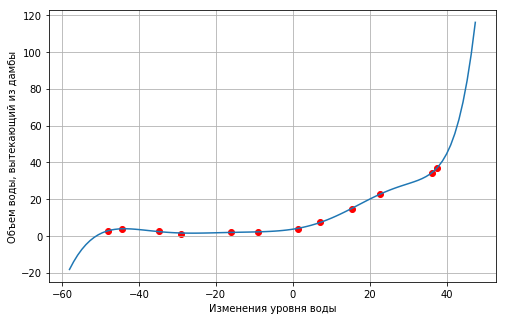

In [553]:
draw_theta(theta_poly_2, X_train, y_train)

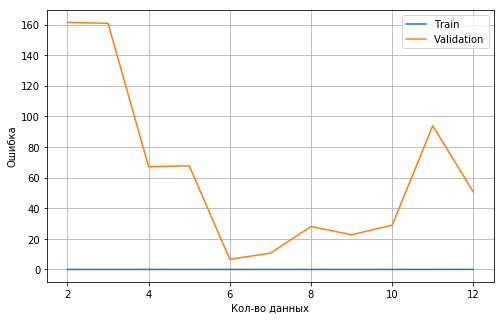

train_error: 0.03121924484764571
validation_error: 50.69359056624195


In [554]:
_, _ = draw_learning_curves(X_train_poly_norm, y_train, X_valid_poly_norm, y_valid)

Если посмотреть на график функции, то видно, что она очень хорошо обучилась на "train" данных и имеет большой процент точности, в то же время, если посмотреть на график "learning curves", то мы увидим, что ошибка "train" очень мала -  0.03, а ошибка "validation" большая - 45.5. Эти показатели свидетельствуют о том, что модель "переобучилась" (overfitting, high variance). Для того, чтобы модель не переобучилась, можно использовать L2-регуляризацию.

**11. Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?**

Для lambda = 1

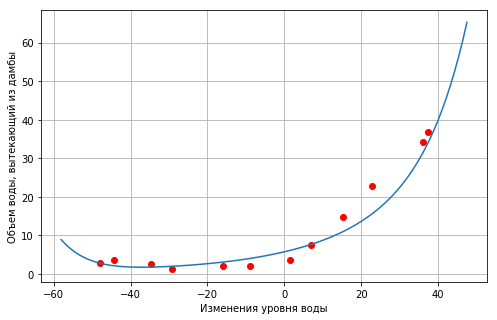

In [560]:
lambda_1 = 1

theta_poly_reg_1 = lin_reg(X_train_poly_norm, y_train, lambda_1)
draw_theta(theta_poly_reg_1, X_train, y_train)

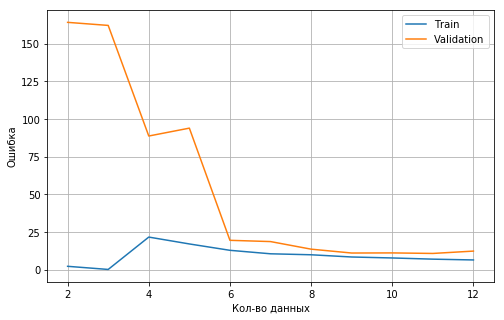

train_error: 6.493171435615369
validation_error: 12.367444036173632


In [561]:
_, _ = draw_learning_curves(X_train_poly_norm, y_train, X_valid_poly_norm, y_valid, lambda_1)

Если посмотреть на гарфик фкнции при (lambda = 1), то можно заметить, что хоть модель и не имеет такой процент точности как при (lambda = 0) однако она довольно точно обобщает входящие данных. Если посмотреть на график "learning curves" то мы увидим, что хоть ошибка "train" возросла с 0.03 до 6.49, зато ошибка "validation" уменьшилась с 45.5 до 12.3. Даныне метрики говорят о том, что у модели отсутсовует "overfitting, high variance" и "underfitting, high bias".

Для lambda = 100

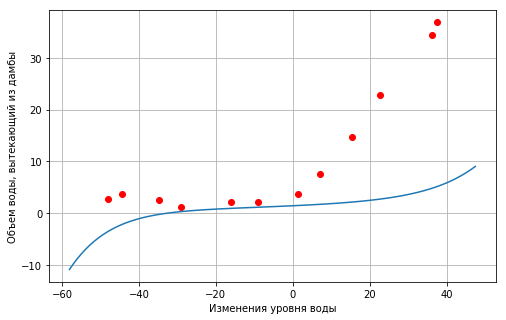

In [563]:
lambda_100 = 100

theta_poly_reg_100 = lin_reg(X_train_poly_norm, y_train, lambda_100)
draw_theta(theta_poly_reg_100, X_train, y_train)

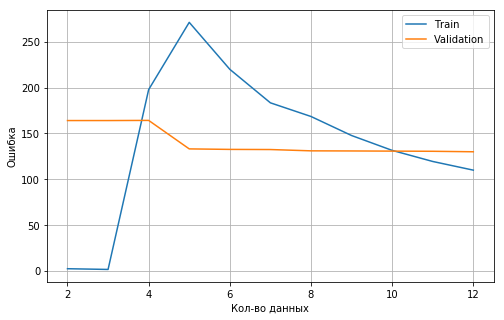

train_error: 109.80372494878571
validation_error: 129.86636806575024


In [564]:
_, _ = draw_learning_curves(X_train_poly_norm, y_train, X_valid_poly_norm, y_valid, lambda_100)

Если посмотреть на гарфик фкнции при (lambda = 100), то можно заметить, что хоть модель очень плохо обобщает входящие данные, и по графику она поможа на модель без полиномиальных признаков.  Если посмотреть на график "learning curves" то мы увидим, что ошибки  "train" и "validation" очень вклики, что говорит нам о том, что модель "недообучена"(underfitting, high bias). Решить проблему можно уменьшив параметр lambda.

**12. С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).**

In [618]:
lambdas = np.linspace(0, 2.5, 16)
train_error = []
validation_error = []

for i in range(len(lambdas)):
    lmb = lambdas[i]
    
    theta_lmbd = lin_reg(X_train_poly_norm, y_train, lmb)

    train_error.append(J(theta_lmbd, X_train_poly_norm, y_train, lmb))
    validation_error.append(J(theta_lmbd, X_valid_poly_norm, y_valid, lmb))

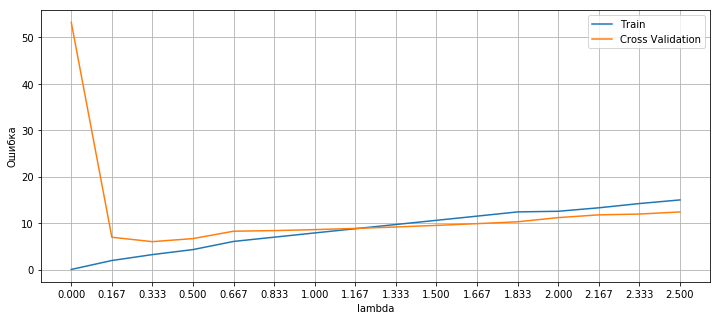

In [620]:
plt.figure(figsize=(12,5))
plt.plot(lambdas, train_error, label='Train')
plt.plot(lambdas, validation_error, label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Ошибка')
plt.xticks(lambdas)
plt.grid(True)

**13. Вычислите ошибку (потерю) на контрольной выборке.**

In [622]:
best_lambda = 1.17

In [623]:
best_theta = lin_reg(X_train_poly_norm, y_train, best_lambda)

In [631]:
train_j = J(best_theta, X_train_poly_norm, y_train, best_lambda)
valid_j = J(best_theta, X_valid_poly_norm, y_valid, best_lambda)


X_test_poly = gen_polynom(X_test, p)
X_test_poly_norm = norm_func(X_test_poly)

test_j = J(best_theta, X_test_poly_norm, y_test, best_lambda)

In [632]:
print(f'train_j = {train_j}')
print(f'valid_j = {valid_j}')
print(f'test_j = {test_j}')

train_j = 8.821571706513591
valid_j = 8.876200901441967
test_j = 7.111563401085762
